In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
from __future__ import print_function, division # bring the print function and division of Python3 to 2.7

In [2]:
plt.style.use('seaborn-poster')

In [3]:
def exp_decay(x, A, t, y0):
    return A * np.exp(-x / t) + y0

def gauss(x, mu, sigma, N):
    return N / np.sqrt(2*np.pi)/sigma * np.exp(-0.5*(x - mu)**2/sigma**2)


### Ajustament d'une exponential

On va utilizer le metode de hit and miss pour generer une distribution de données exponential 


Parameters pour l'exponnential

In [4]:
t = 200.
A = 1/t 
y0 = 0.
xmax = 1200


In [5]:
mc_events = 10000

In [6]:
rnd1 = np.random.rand(mc_events)
rnd2 = np.random.rand(mc_events)
y = A*rnd1
x = xmax*rnd2
yprime = exp_decay(x, A, t, y0)

data = x[np.where(y < yprime)]

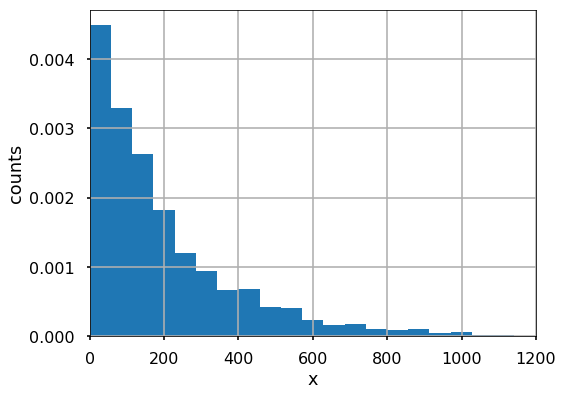

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
plt.grid()
hist, binsedges, patches = ax.hist(data,bins = 20, normed=True)
ax.set_xlabel("x")
ax.set_ylabel("counts")
ax.set_xlim(0,1200)
plt.show()

### Minimization using the chi-squared method

We are going to fit the *binned data*, c-a-d the content of each bin and compared with the prediction of our model for each binned. 

In [8]:
binscenters = binsedges[:-1] + np.diff(binsedges)/2.

tmin = 100.
tmax = 300.

Q = []

tt = np.arange(tmin, tmax, 1.)

for tau in tt:
    Q.append(
        np.sum((hist - exp_decay(binscenters,1/tau, tau, y0))**2/hist)) 
        
tbest = tt[np.where(Q == np.min(Q))]

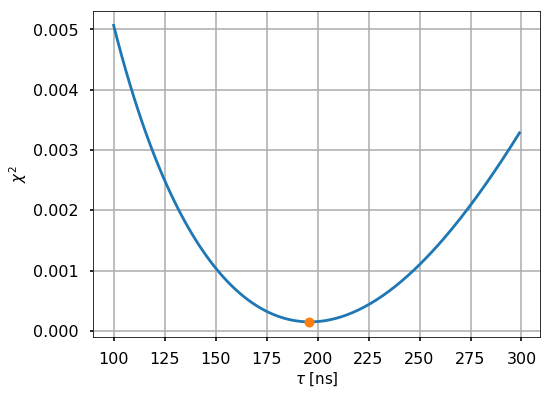

In [9]:
fig3, ax3 = plt.subplots(figsize=(8,6))
plt.grid()
ax3.plot(tt, Q)
ax3.set_xlabel(r"$\tau$ [ns]", fontsize=15)
ax3.set_ylabel("$\chi^2$", fontsize=15)
ax3.plot(tbest, np.min(Q),'o', ms=10)
plt.show()

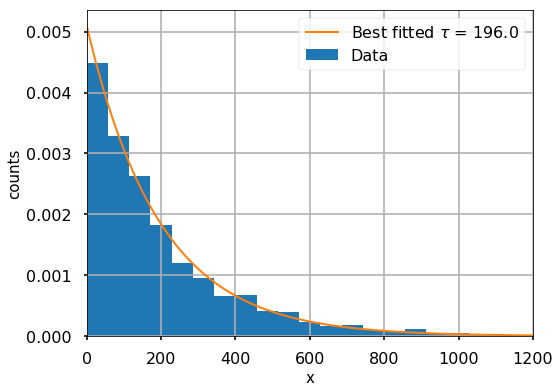

In [10]:
fig2, ax2 = plt.subplots(figsize=(8,6))
plt.grid()
ax2.hist(data,bins = 20,normed=True, label="Data")
x = np.arange(0, xmax, 0.1)

# If the histogram is NOT normalized (normed = False) I need to rescale the PDF by the number of mc event and the binwidth
#  binwidth = np.diff(bins)[0]
#  ax4.plot(x, exp_decay(x, 1/tbest*len(data2)*binwidth, tbest, y0), lw =2 , label=r"Best fitted $\tau$ = %.1f"%tbest)

ax2.plot(x, exp_decay(x, 1/tbest, tbest, y0), lw =2 , label=r"Best fitted $\tau$ = %.1f"%tbest)

ax2.set_xlabel("x", fontsize=15)
ax2.set_ylabel("counts", fontsize=15)
ax2.set_xlim(0,1200)
ax2.legend()
plt.show()

### Ajustement d'une gaussiane

Parametres pour la gaussiane

In [11]:
mu = 200
sigma = 50
N = 1.

xmin = mu - 5*sigma
xmax = mu + 5*sigma
mc_events = 1000000

Maintenant on va faire le méthode du Hit & Miss pour generer une gaussiene

In [12]:
rnd1 = np.random.rand(mc_events)
rnd2 = np.random.rand(mc_events)
y = N*rnd1
x = xmin + (xmax - xmin)*rnd2
yprime = gauss(x, mu, sigma, N)

data = x[np.where(y < yprime)]

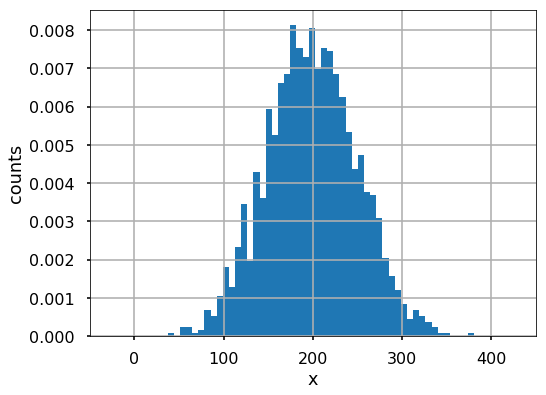

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
plt.grid()
hist, binsedges, patches = ax.hist(data,bins = 50, normed=True)
ax.set_xlabel("x")
ax.set_ylabel("counts")
ax.set_xlim(xmin, xmax)
plt.show()

### Minimization using the Likelihood method

Here we are going to use the raw-data ie, we are not going to use the histogram but directly the array data

In [14]:
mumin = 195.
mumax = 205.
L = []

mm = np.arange(mumin, mumax, 0.01)

for m in mm:
    P = gauss(data, m, sigma, 1.)
    L.append(-np.sum(np.log(P)))
    
mubest = mm[np.where(L == np.min(L))]

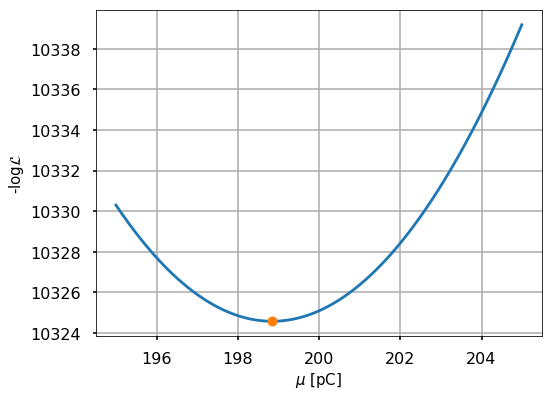

In [15]:
fig1, ax1 = plt.subplots(figsize=(8,6))
plt.grid()
ax1.plot(mm, L)
ax1.set_xlabel(r"$\mu$ [pC]", fontsize=15)
ax1.set_ylabel("-$\log \mathcal{L}$", fontsize=15)
ax1.plot(mubest, np.min(L),'o', ms=10)

plt.show()



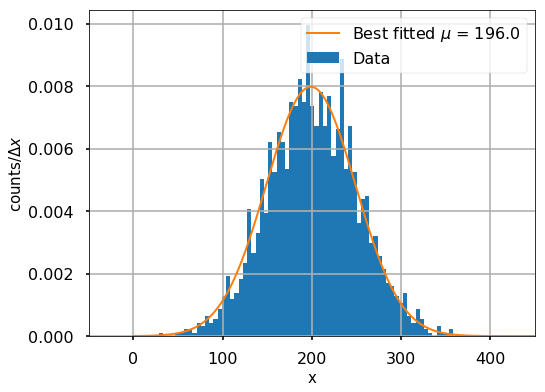

In [20]:
fig2, ax2 = plt.subplots(figsize=(8,6))
plt.grid()
ax2.hist(data,bins = 70,normed=True, label="Data")
x = np.arange(0, xmax, 0.1)

# If the histogram is NOT normalized (normed = False) I need to rescale the PDF by the number of mc event and the binwidth
#  binwidth = np.diff(bins)[0]
#  ax4.plot(x, exp_decay(x, 1/tbest*len(data2)*binwidth, tbest, y0), lw =2 , label=r"Best fitted $\tau$ = %.1f"%tbest)

ax2.plot(x, gauss(x, mubest, sigma, 1.), lw =2 , label=r"Best fitted $\mu$ = %.1f"%tbest)

ax2.set_xlabel("x", fontsize=15)
ax2.set_ylabel("counts/$\Delta x$", fontsize=15)
ax2.set_xlim(xmin, xmax)
ax2.legend(loc="upper right")
plt.show()

[197.7  197.71 197.72 199.98 199.99]
[1.15 1.14 1.13 1.13 1.14]


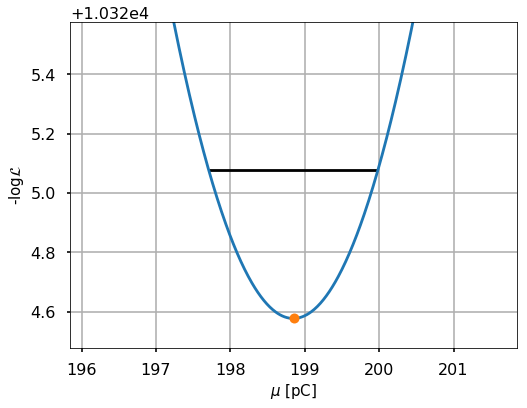

In [17]:
fig1, ax1 = plt.subplots(figsize=(8,6))
plt.grid()
ax1.plot(mm, L)
ax1.set_xlabel(r"$\mu$ [pC]", fontsize=15)
ax1.set_ylabel("-$\log \mathcal{L}$", fontsize=15)
ax1.plot(mubest, np.min(L),'o', ms=10)
musigmas = (mm[np.where(np.isclose(L, np.min(L) + 0.5,rtol=1e-6))])
print (musigmas)
ax1.hlines(y = np.min(L) + 0.5,xmin=musigmas[0], xmax=musigmas[-1])
sigmas = np.abs(musigmas - mubest)
print (sigmas)
ax1.set_ylim(np.min(L) - 0.1, np.min(L) + 1)
ax1.set_xlim(mubest - 3,mubest + 3)
plt.show()




In [18]:
mumin = 100.
mumax = 300.

mm = np.arange(mumin, mumax, 0.5)

mubests = []
    
for i in range(0, 1000):
    rnd1 = np.random.rand(mc_events)
    rnd2 = np.random.rand(mc_events)
    y = N*rnd1
    x = xmin + (xmax - xmin)*rnd2
    yprime = gauss(x, mu, sigma, N)

    data = x[np.where(y < yprime)]
    L = []
    for m in mm:
        P = gauss(data, m, sigma, 1.)
        L.append(-np.sum(np.log(P)))
    mubests.append(mm[np.where(L == np.min(L))])

mubests = np.array(mubests).flatten()

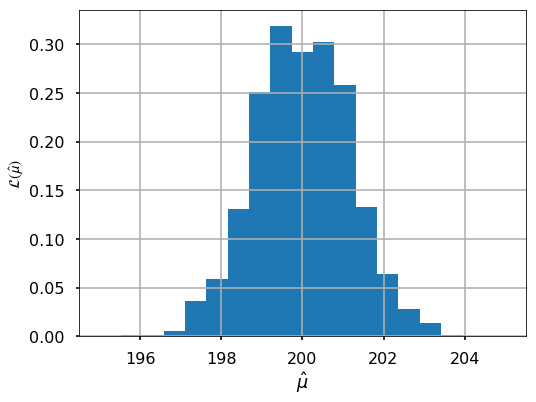

In [19]:
fig1, ax1 = plt.subplots(figsize=(8,6))
plt.grid()
ax1.hist(mubests, bins = np.linspace(195, 205, 20), normed=True)
ax1.set_ylabel("$\mathcal{L(\hat{\mu})}$", fontsize=15)
ax1.set_xlabel("$\hat{\mu}$")
plt.show()